Title: Boston Crimes Data Analysis

Author: Junyi Zheng

The data is crime incident reports in Boston from August 2015 - present. It is published by Department of Innovation and Technology. It is provided by Boston Police Department (BPD) to document the initial details surrounding an incident to which BPD officers respond. This is a dataset containing records from the new crime incident report system, which includes a reduced set of fields focused on capturing the type of incident as well as when and where it occurred. The dataset has a bunch of fields, including offense category, offense districts, offense data and offense coordinates. 

With this dataset, one can analyze several factors that may relate to crimes. For instance, the relationship between the day of week that crimes happened and the category of crimes. Furthermore, the most safest places and most dangerous places can be marked on a map.

In [30]:
# usual things
import pandas as pd
import matplotlib.pyplot as plt
import bqplot
import numpy as np
import ipywidgets
import time as systime
import datetime as dt
import string
import seaborn as sns
import bqplot.pyplot as pt
%matplotlib inline

In [31]:
data = pd.read_csv('bostoncrime.csv')
data = data.dropna()
data["DISTRICT"] = data["DISTRICT"].astype('category')
data["dis"] = data["DISTRICT"].cat.codes

data['OCCURRED_ON_DATE'] = pd.to_datetime(data['OCCURRED_ON_DATE'])
data['year'] = data.OCCURRED_ON_DATE.dt.year
data['month'] = data.OCCURRED_ON_DATE.dt.month
data['day'] = data.OCCURRED_ON_DATE.dt.day
data['hour'] = data.OCCURRED_ON_DATE.dt.hour

total_crm = data.groupby([data['day'],data['DISTRICT']])['INCIDENT_NUMBER'].count().reset_index()
total_crm["DISTRICT"] = total_crm["DISTRICT"].astype('category')
total_crm["dis"] = total_crm["DISTRICT"].cat.codes
total_crm["inci"] = total_crm["INCIDENT_NUMBER"]

In [32]:
a = data[(data.day==1)&(data.dis==2)].index.tolist()
hist2d, ag_edges, dist_edges = np.histogram2d(total_crm['day'], 
                                              total_crm['dis'], 
                                              weights = total_crm['inci'], 
                                              bins=[31,9])

ag_centers = (ag_edges[:-1] + ag_edges[1:])/2
dist_centers = (dist_edges[:-1] + dist_edges[1:])/2
hist2d = hist2d.T
hist2d[hist2d<= 0] = np.nan

hist2d = np.log10(hist2d)

In [47]:
cn = data.groupby([data['day'],data['DISTRICT'],data['OFFENSE_CODE_GROUP']])['INCIDENT_NUMBER'].count().reset_index()
cn["DISTRICT"] = cn["DISTRICT"].astype('category')
cn["dis"] = cn["DISTRICT"].cat.codes
cn["inci"] = cn["INCIDENT_NUMBER"]

# CREATE LABEL - #1
mySelectedLabel = ipywidgets.Label() # print out info about our selection

In [48]:
# scales
x_sc = bqplot.LinearScale()
y_sc = bqplot.LinearScale() 
col_sc = bqplot.ColorScale(scheme='BuPu', min=np.nanmin(hist2d), max=np.nanmax(hist2d))

# axis
x_ax = bqplot.Axis(scale=x_sc, label='day')
y_ax = bqplot.Axis(scale=y_sc, label='District', orientation='vertical')
c_ax = bqplot.ColorAxis(scale=col_sc, orientation='vertical', side='right')

# marks
heat_map = bqplot.GridHeatMap(color=hist2d, 
                             row=dist_centers, 
                             column=ag_centers, 
                             scales={'color':col_sc, 'row':y_sc, 'column':x_sc},
                             interactions={'click':'select'}, 
                             anchor_style={'fill':'blue'})

In [59]:
x_ord = bqplot.OrdinalScale()
y_sc = bqplot.LinearScale()

ax_x = bqplot.Axis(label='Crime Category', scale=x_ord, orientation='vertical', fontsize=10)
ax_y = bqplot.Axis(label='Crime Number',scale=y_sc, tick_format='0.2f')

bar = bqplot.Bars(x=cn['OFFENSE_CODE_GROUP'], y=cn['inci'], scales={'x': x_ord, 'y': y_sc}, orientation='horizontal', color_mode='group')
# bqplot.Figure(marks=[bar], axes=[ax_x, ax_y])

In [60]:
# LINKING BAR PLOT WITH HEATMAP
def get_data_value(change):
    # to make sure we only support single selections
    if len(change['owner'].selected) == 1: # *only* 1 selection
        i,j = change['owner'].selected[0]
        v = hist2d[i,j]
        mySelectedLabel.value = 'Crime Number' + str(v)
        ags = [ag_edges[j], ag_edges[j+1]]
        dists = [dist_edges[i], dist_edges[i+1]]
        region_mask = ( (cn['day'] >= ags[0]) & (cn['day'] <= ags[1]) &\
                       (cn['dis'] >= dists[0]) & (cn['dis']<= dists[1]) )
        bar.x = cn['OFFENSE_CODE_GROUP'][region_mask]
        bar.y = cn['inci'][region_mask]
          
heat_map.observe(get_data_value, 'selected')

In [62]:
fig_heatmap = bqplot.Figure(marks=[heat_map], axes=[c_ax, y_ax, x_ax], title = 'Number of Crimse in Each District vs Day')
fig_num = bqplot.Figure(marks=[bar], axes=[ax_x, ax_y], title = 'Number of Crimes in Categories')

fig_heatmap.layout.min_width='400px'
fig_num.layout.min_width = '400px'

plots = ipywidgets.HBox([fig_heatmap, fig_num])
myDashboard = ipywidgets.VBox([mySelectedLabel, plots])
myDashboard

This interactive data visualization above shows that the number of crimes is related to the day in a month. As the darkness of the color varies hugely among the pieces. It is obvious that in district 9 there are few crimes in the first half month, the number increased on the 18th of the month.This is somehow very interesting. Moreover, from the left part we can see that district 3, 4 and 5 are the most dangerous places which people should avoid. By selecting any tiny squares on the left side, a bar plot will show on the right side that illustrates how many crimes and which kind of crimes they are. This helps people discover the ratios that consist of the crime number. It will be clear to see which kinds of crimes are significantly more than others. Finally, it may be benefit for the police to manage the departments. For example, the department that is in charge of the the crime category that has the most number should be assigned with more people, and vise versa.

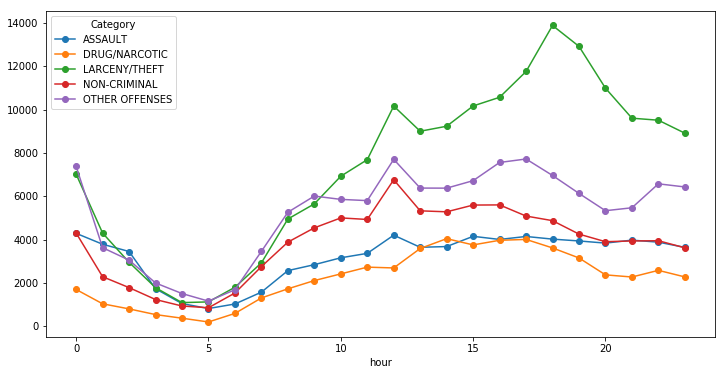

In [70]:
train = pd.read_csv('train.csv')
train['date'] = pd.to_datetime(train['Dates'])
train['hour'] = train.date.dt.hour
cate_group = train.groupby(by='Category').size()

cate_group.index = cate_group.index.map(string.capwords)
cate_group.sort_values(ascending=False,inplace=True)
most = list(cate_group.index[:5])
tmp = train[train['Category'].map(string.capwords).isin(most)]
tmp_group = tmp.groupby(['Category','hour']).size()
tmp_group = tmp_group.unstack()
tmp_group.T.plot(figsize=(12,6),style='o-')
plt.show()

This dataset is the San Francisco crime data. It shows the different kinds of crimes numbers in every hour. It helps to compare with Boston crime data. It reveals similarity and differences betweens the two cities. 

In [76]:
#!pip install pyecharts

     |████████████████████████████████| 133kB 2.6MB/s eta 0:00:01
     |████████████████████████████████| 81kB 15.4MB/s eta 0:00:01
  Created wheel for prettytable: filename=prettytable-0.7.2-cp37-none-any.whl size=13700 sha256=9cd5c41810d55d361bec960b0ce469f3396a3751b833d59047b3acb61fa1f6b4
  Stored in directory: /Users/zhengjunyi/Library/Caches/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
Successfully built prettytable


In [79]:
from pyecharts.charts import Pie, Bar, Map, WordCloud,Line,Grid,Scatter,Radar,Page
from pyecharts import options as opts
district = train['PdDistrict'].value_counts()
def pie_rosetype(col) -> Pie:
#     v = Faker.choose()
    c = (
        Pie()
        .add(
            "",
            [list(z) for z in zip(district.index.tolist(), 
                                  district.values.tolist())],
            radius=["30%", "75%"],
            center=["50%", "50%"],
            rosetype="radius",
            label_opts=opts.LabelOpts(is_show=False),
        )
        .set_global_opts(title_opts=opts.TitleOpts(title="Districts Ratio"),
                        legend_opts=opts.LegendOpts(
            orient="vertical", pos_top="20%", pos_left="0.5%"
        ))
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    )
    return c
pie_rosetype(district).render_notebook()

The above visulization shows the ratio of number of crimes in different districts in San Francisco.

### 5. citation

https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system

https://www.kaggle.com/roshansharma/sanfrancisco-crime-analysis